In [1]:
%pip install numpy pandas scikit-learn matplotlib seaborn nltk

import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KUNJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KUNJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('D:/PROJECTS/AIML/FAKE JOB DETECTION SYSTEM/fake_job_postings.csv')
print("Dataset Structure:\n", df.head())
print("\nDataset Info:\n")
df.info()

Dataset Structure:
    job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         d

In [4]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in tokens if word not in stop_words])
    return text

# Combine 'title' and 'description' columns for analysis
df['text'] = df['title'].fillna('') + " " + df['description'].fillna('')
df['text'] = df['text'].apply(preprocess_text)

# Ensure 'label' column exists before dropping rows with missing labels or text
if 'label' in df.columns:
    df = df.dropna(subset=['text', 'label'])
else:
    df = df.dropna(subset=['text'])


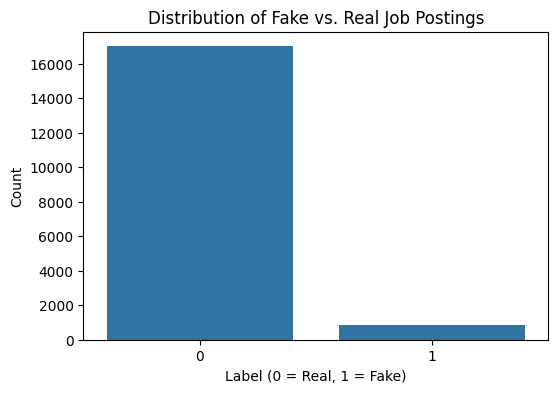

In [5]:
# Rename 'fraudulent' column to 'label'
df.rename(columns={'fraudulent': 'label'}, inplace=True)

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Distribution of Fake vs. Real Job Postings")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.show()

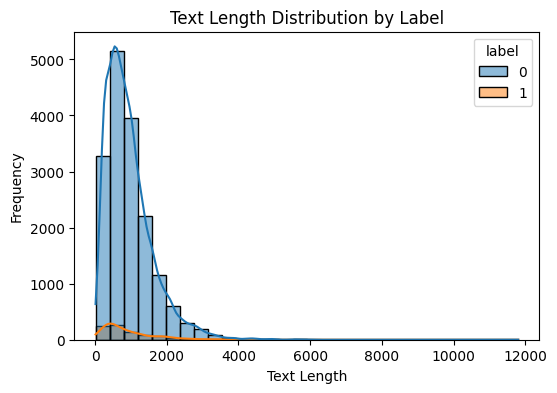

In [6]:
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='text_length', hue='label', bins=30, kde=True)
plt.title("Text Length Distribution by Label")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [7]:
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X = tfidf.fit_transform(df['text']).toarray()
y = df['label']  # Target variable

# Save the TF-IDF vectorizer for future use
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Save the trained model for deployment
with open('fake_job_detection_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [10]:
y_pred = model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9773489932885906

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.99      0.56      0.71       181

    accuracy                           0.98      3576
   macro avg       0.98      0.78      0.85      3576
weighted avg       0.98      0.98      0.97      3576



In [11]:
def predict_job_posting(title, description):
    """
    Predict whether a job posting is fake or real.
    """
    text = preprocess_text(title + " " + description)
    text_vector = tfidf.transform([text]).toarray()
    prediction = model.predict(text_vector)
    return "Fake" if prediction[0] == 1 else "Real"

In [12]:
# Example Prediction
sample_title = "Immediate Hire: Data Entry"
sample_description = "No experience required. Earn money quickly by working remotely."
print("\nPrediction for the sample job posting:", predict_job_posting(sample_title, sample_description))


Prediction for the sample job posting: Real
